# Entire workflow

In [1]:
# import libraries
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
path_image = r"C:\Users\91879\Downloads\anemia-detection-main\database_sclere\Italiano congiuntive\Dataset congiuntive italiano segmentato\T_9_20190607_075803\T_9_20190607_075803.jpg"
assert path_image!='', 'Please specify the image path!'
# Load the image in RGB format
image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
# Resizing image for faster processing (OPTIONAL but RECOMMENDED)
height, width, _ = image.shape
aspect_ratio = width / height
new_width = 500
new_height = int(new_width / aspect_ratio)

image = cv2.resize(image, (new_width, new_height))

## 1. Segmentation of sclera

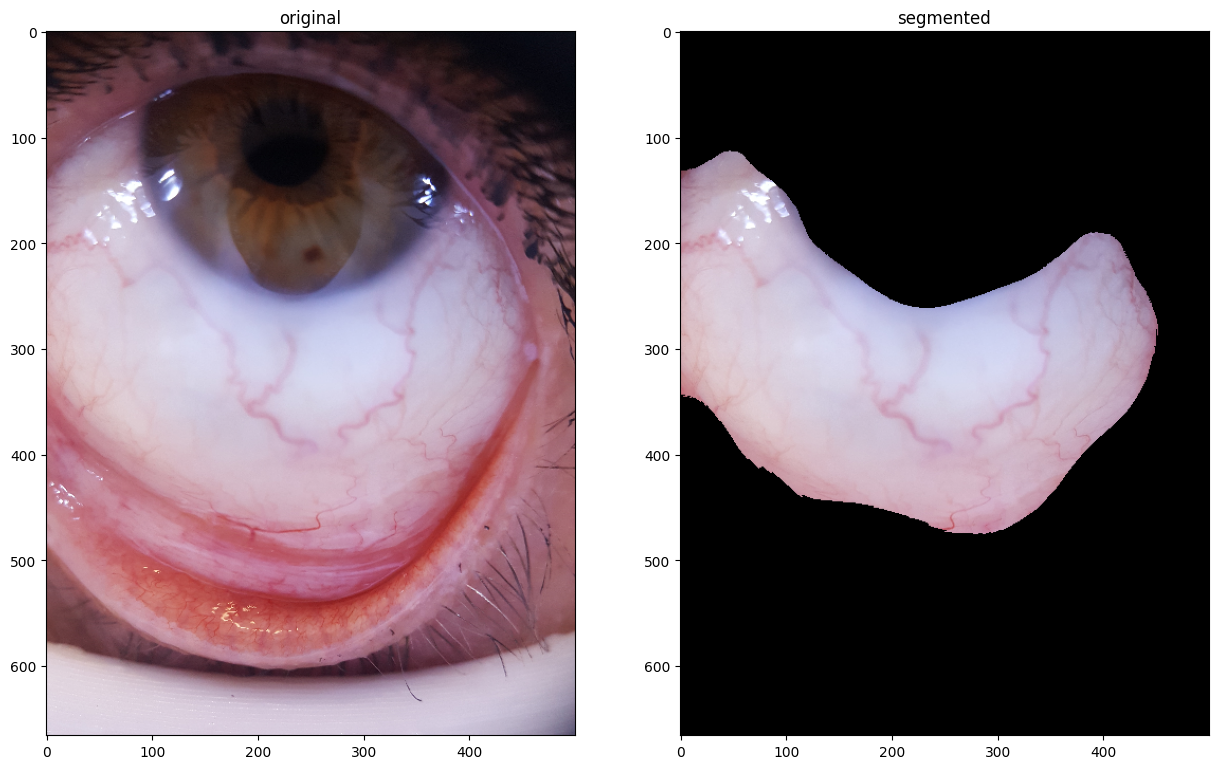

In [4]:
from sclera_segmentation import segmentation

mask_sclera, _, _, _ = segmentation.segment(image)
img_segmented = cv2.bitwise_and(image, image, mask=mask_sclera)

# Plot the segmented image
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("original")
plt.imshow(image)
plt.subplot(122)
plt.title("segmented")
plt.imshow(img_segmented)
plt.show()

## 2. Generation of vessels mask (U-Net)

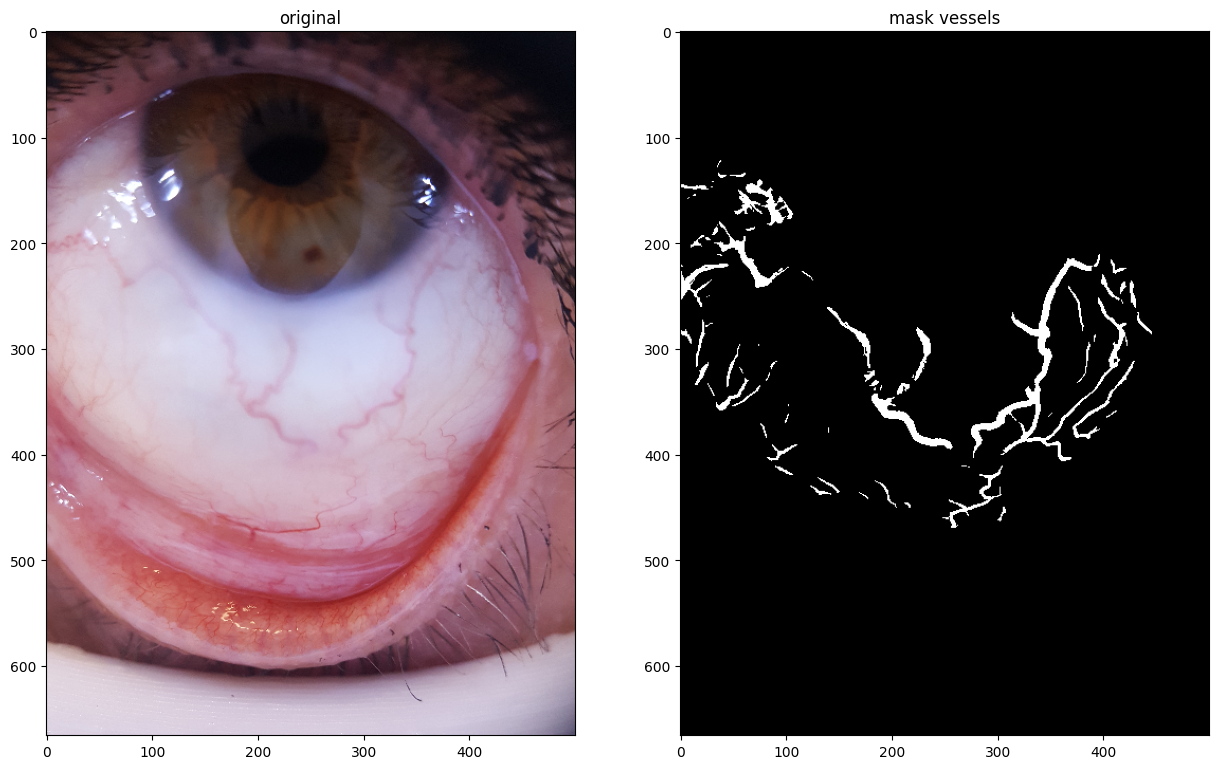

In [5]:
from unet.unet import get_vessels_from_image
    
pred_image = get_vessels_from_image(img_segmented)

# Plot the segmented image
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("original")
plt.imshow(image)
plt.subplot(122)
plt.title("mask vessels")
plt.imshow(pred_image,cmap=plt.cm.gray)
plt.show()


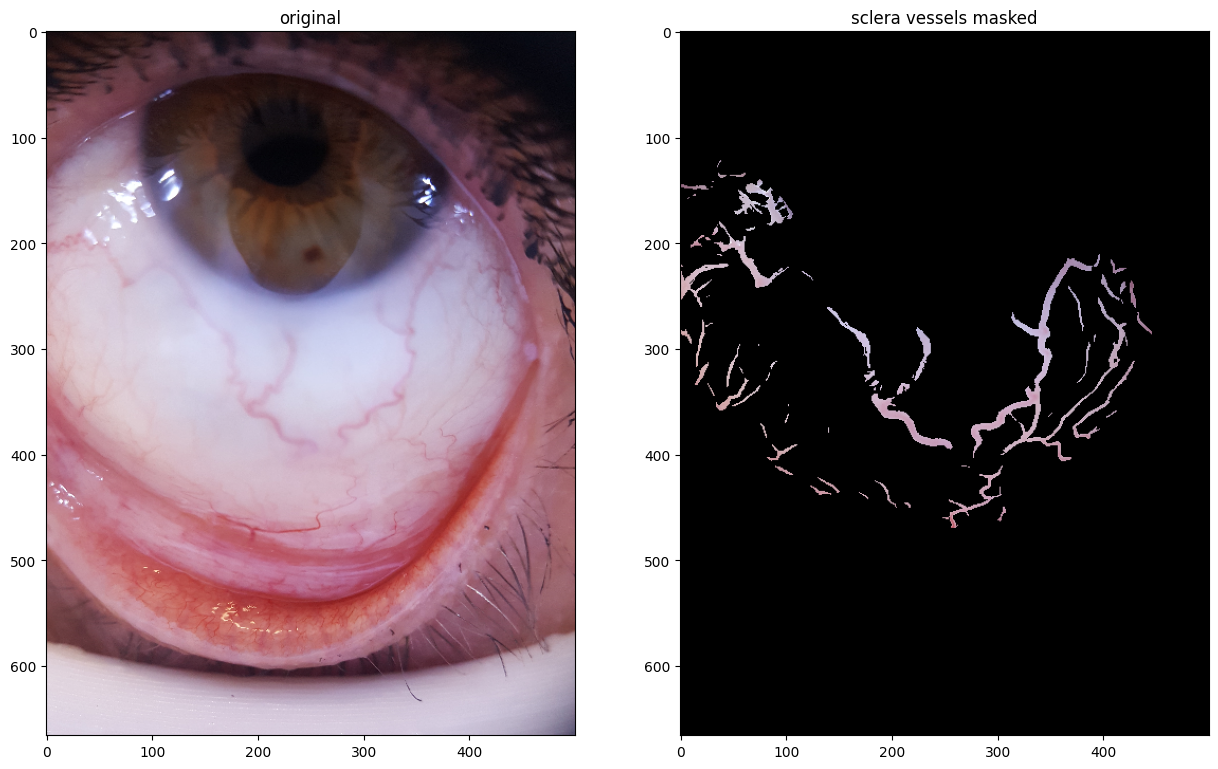

In [6]:
pred_image = pred_image.astype(np.uint8)

sclera_vessels_masked = cv2.bitwise_and(img_segmented, img_segmented, mask=pred_image)

# Plot the segmented image
plt.figure(figsize=(15,15))
plt.subplot(121) 
plt.title("original")
plt.imshow(image)
plt.subplot(122)
plt.title("sclera vessels masked")
plt.imshow(sclera_vessels_masked)
plt.show()

## 3. Evaluation

### 3.1 Preprocessing

In [7]:
from svm.svm import calculate_bgr, adjust_contrast, calculate_lab, extract_white

In [8]:
sclera_quantiles_bgr, vessels_quantiles_bgr, vessels_density, value_r_minous_g_img_sclera, value_r_minous_g_img_vessels, dev_std_sclera, dev_std_vessels = calculate_bgr(img_segmented, sclera_vessels_masked)

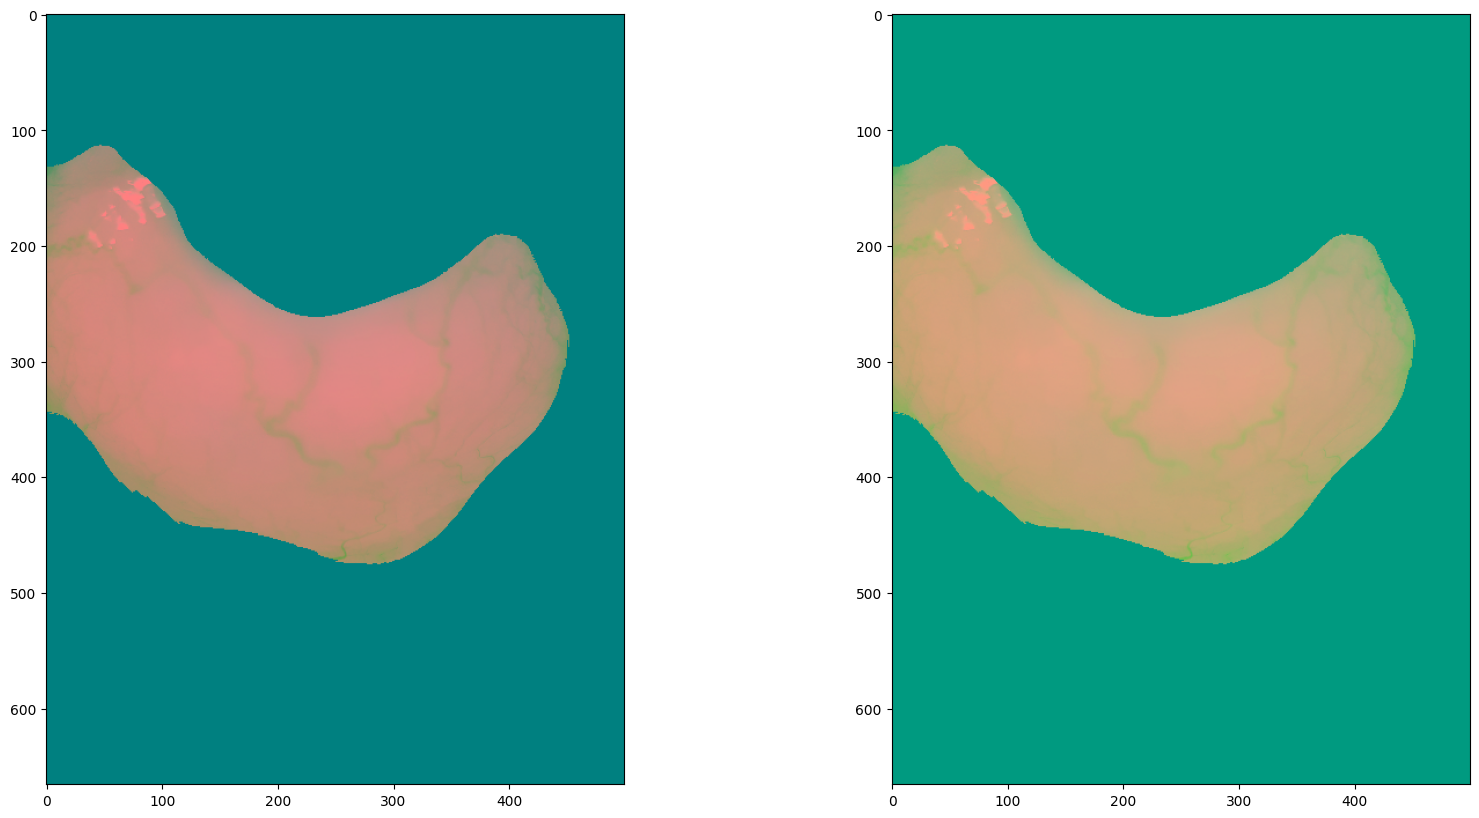

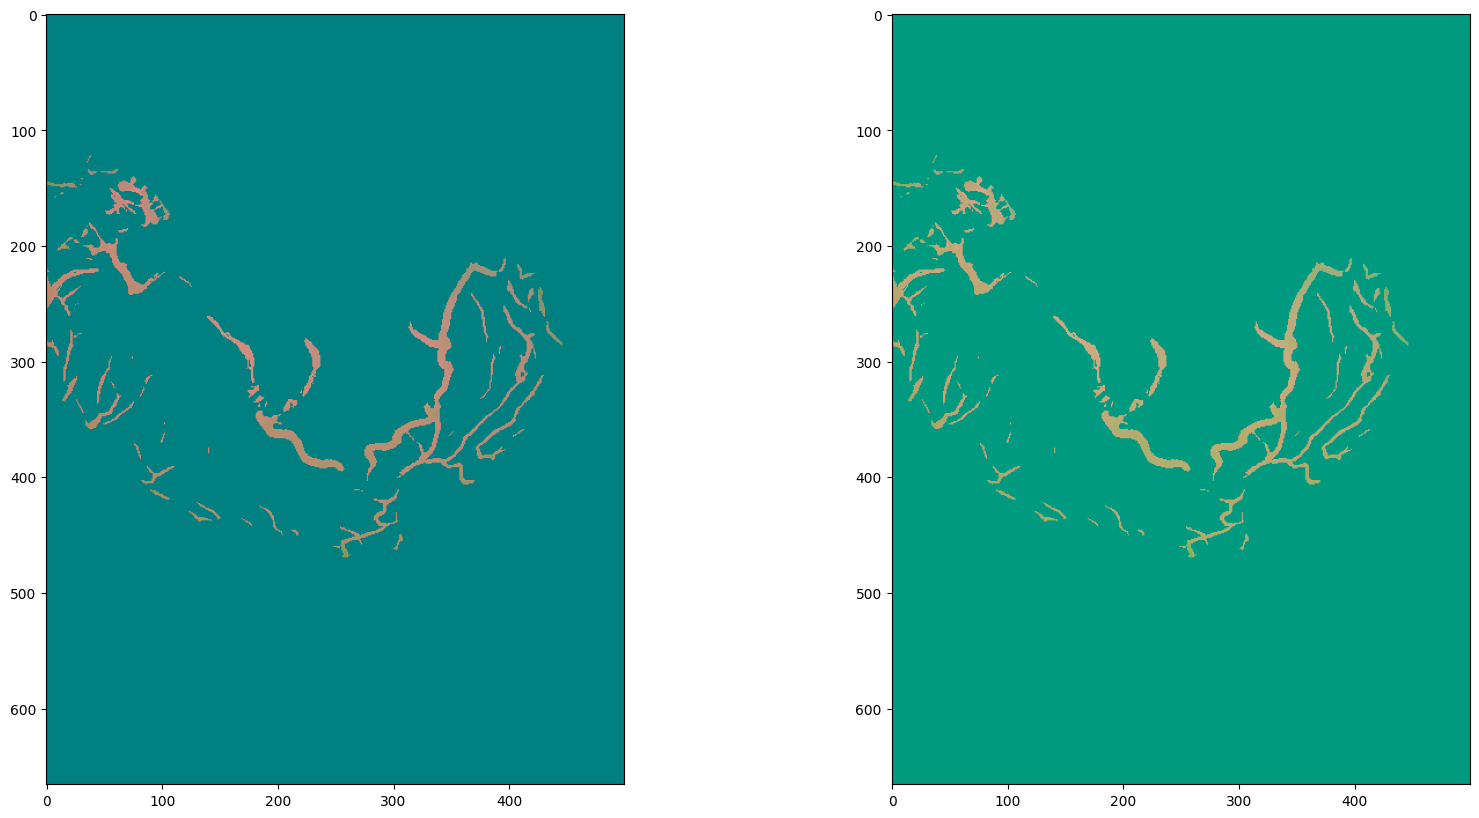

In [9]:
sclera_lab, sclera_vessels_lab = adjust_contrast(img_segmented, sclera_vessels_masked)

In [10]:
value_a_img_sclera, value_a_img_vessels, dev_std_sclera_cielab, dev_std_vessels_cielab, sclera_quantiles_lab, vessels_quantiles_lab = calculate_lab(img_segmented, sclera_lab, sclera_vessels_lab)

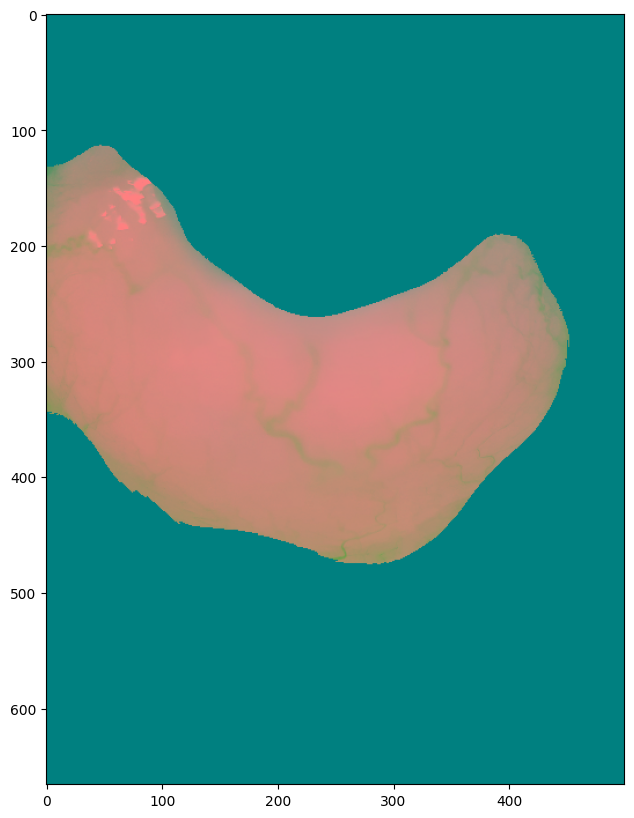

In [11]:
vessels_colors_white_deviations_cielab, vessels_colors_white_quantiles_cielab = extract_white(pred_image, img_segmented)

## 3.2 Prediction

### Load model

In [12]:
import pickle

# Load svm model
filename = 'svm/svm_model.sav'

# Load model
loaded_model = pickle.load(open(filename, 'rb'))

c:\Users\91879\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Get features

In [13]:
# prepare features for the model
X = []

one = vessels_density[0]
tree = value_r_minous_g_img_vessels[0]
four = dev_std_sclera[0][0][0] - dev_std_vessels[0][0][0]
six = sclera_quantiles_bgr[0][2][1]
eight = value_a_img_sclera[0] - value_a_img_vessels[0]
nine = value_a_img_vessels[0]
ten = dev_std_sclera_cielab[0][0][0]
eleven = vessels_quantiles_lab[0][0][1]
twelve = sclera_quantiles_lab[0][2][2] - vessels_quantiles_lab[0][2][2]

# add feature to X list
X.append([one,tree,four,six,eight,nine,ten,eleven,twelve])

In [14]:
y_pred = loaded_model.predict(X)

if y_pred[0] == 1:
    print("The patient has anemia")
else:
    print("The patient has not anemia")

The patient has not anemia
